In [9]:
import pandas as pd
import os

from dotenv import load_dotenv
from parea import Parea

load_dotenv()


p = Parea(api_key=os.getenv("PAREA_API_KEY"))


def analysis(experiment_uuid: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    experiment_stats = p.get_experiment_stats(experiment_uuid)

    dicts = []
    for stats in experiment_stats.parent_trace_stats:
        d = {'trace_id': stats.trace_id}
        for score in stats.scores:
            d[score.name] = score.score
        dicts.append(d)

    df = pd.DataFrame(dicts)
    df_scores = df.copy()
    del df_scores['trace_id']

    df_acc = df_scores.eq(df_scores['hit_rate_top_20'], axis=0).sum() / len(df_scores)
    df_fpr = df_scores.apply(lambda x: (x == 1) & (df_scores['hit_rate_top_20'] == 0)).sum() / len(df_scores)
    df_fnr = df_scores.apply(lambda x: (x == 0) & (df_scores['hit_rate_top_20'] == 1)).sum() / len(df_scores)
    df_comp = pd.concat([df_acc, df_fpr, df_fnr], axis=1, keys=['accuracy', 'fpr', 'fnr'])
    # put index as column
    df_comp.reset_index(inplace=True)
    df_comp.rename(columns={'index': 'eval_metric'}, inplace=True)
    return df_comp

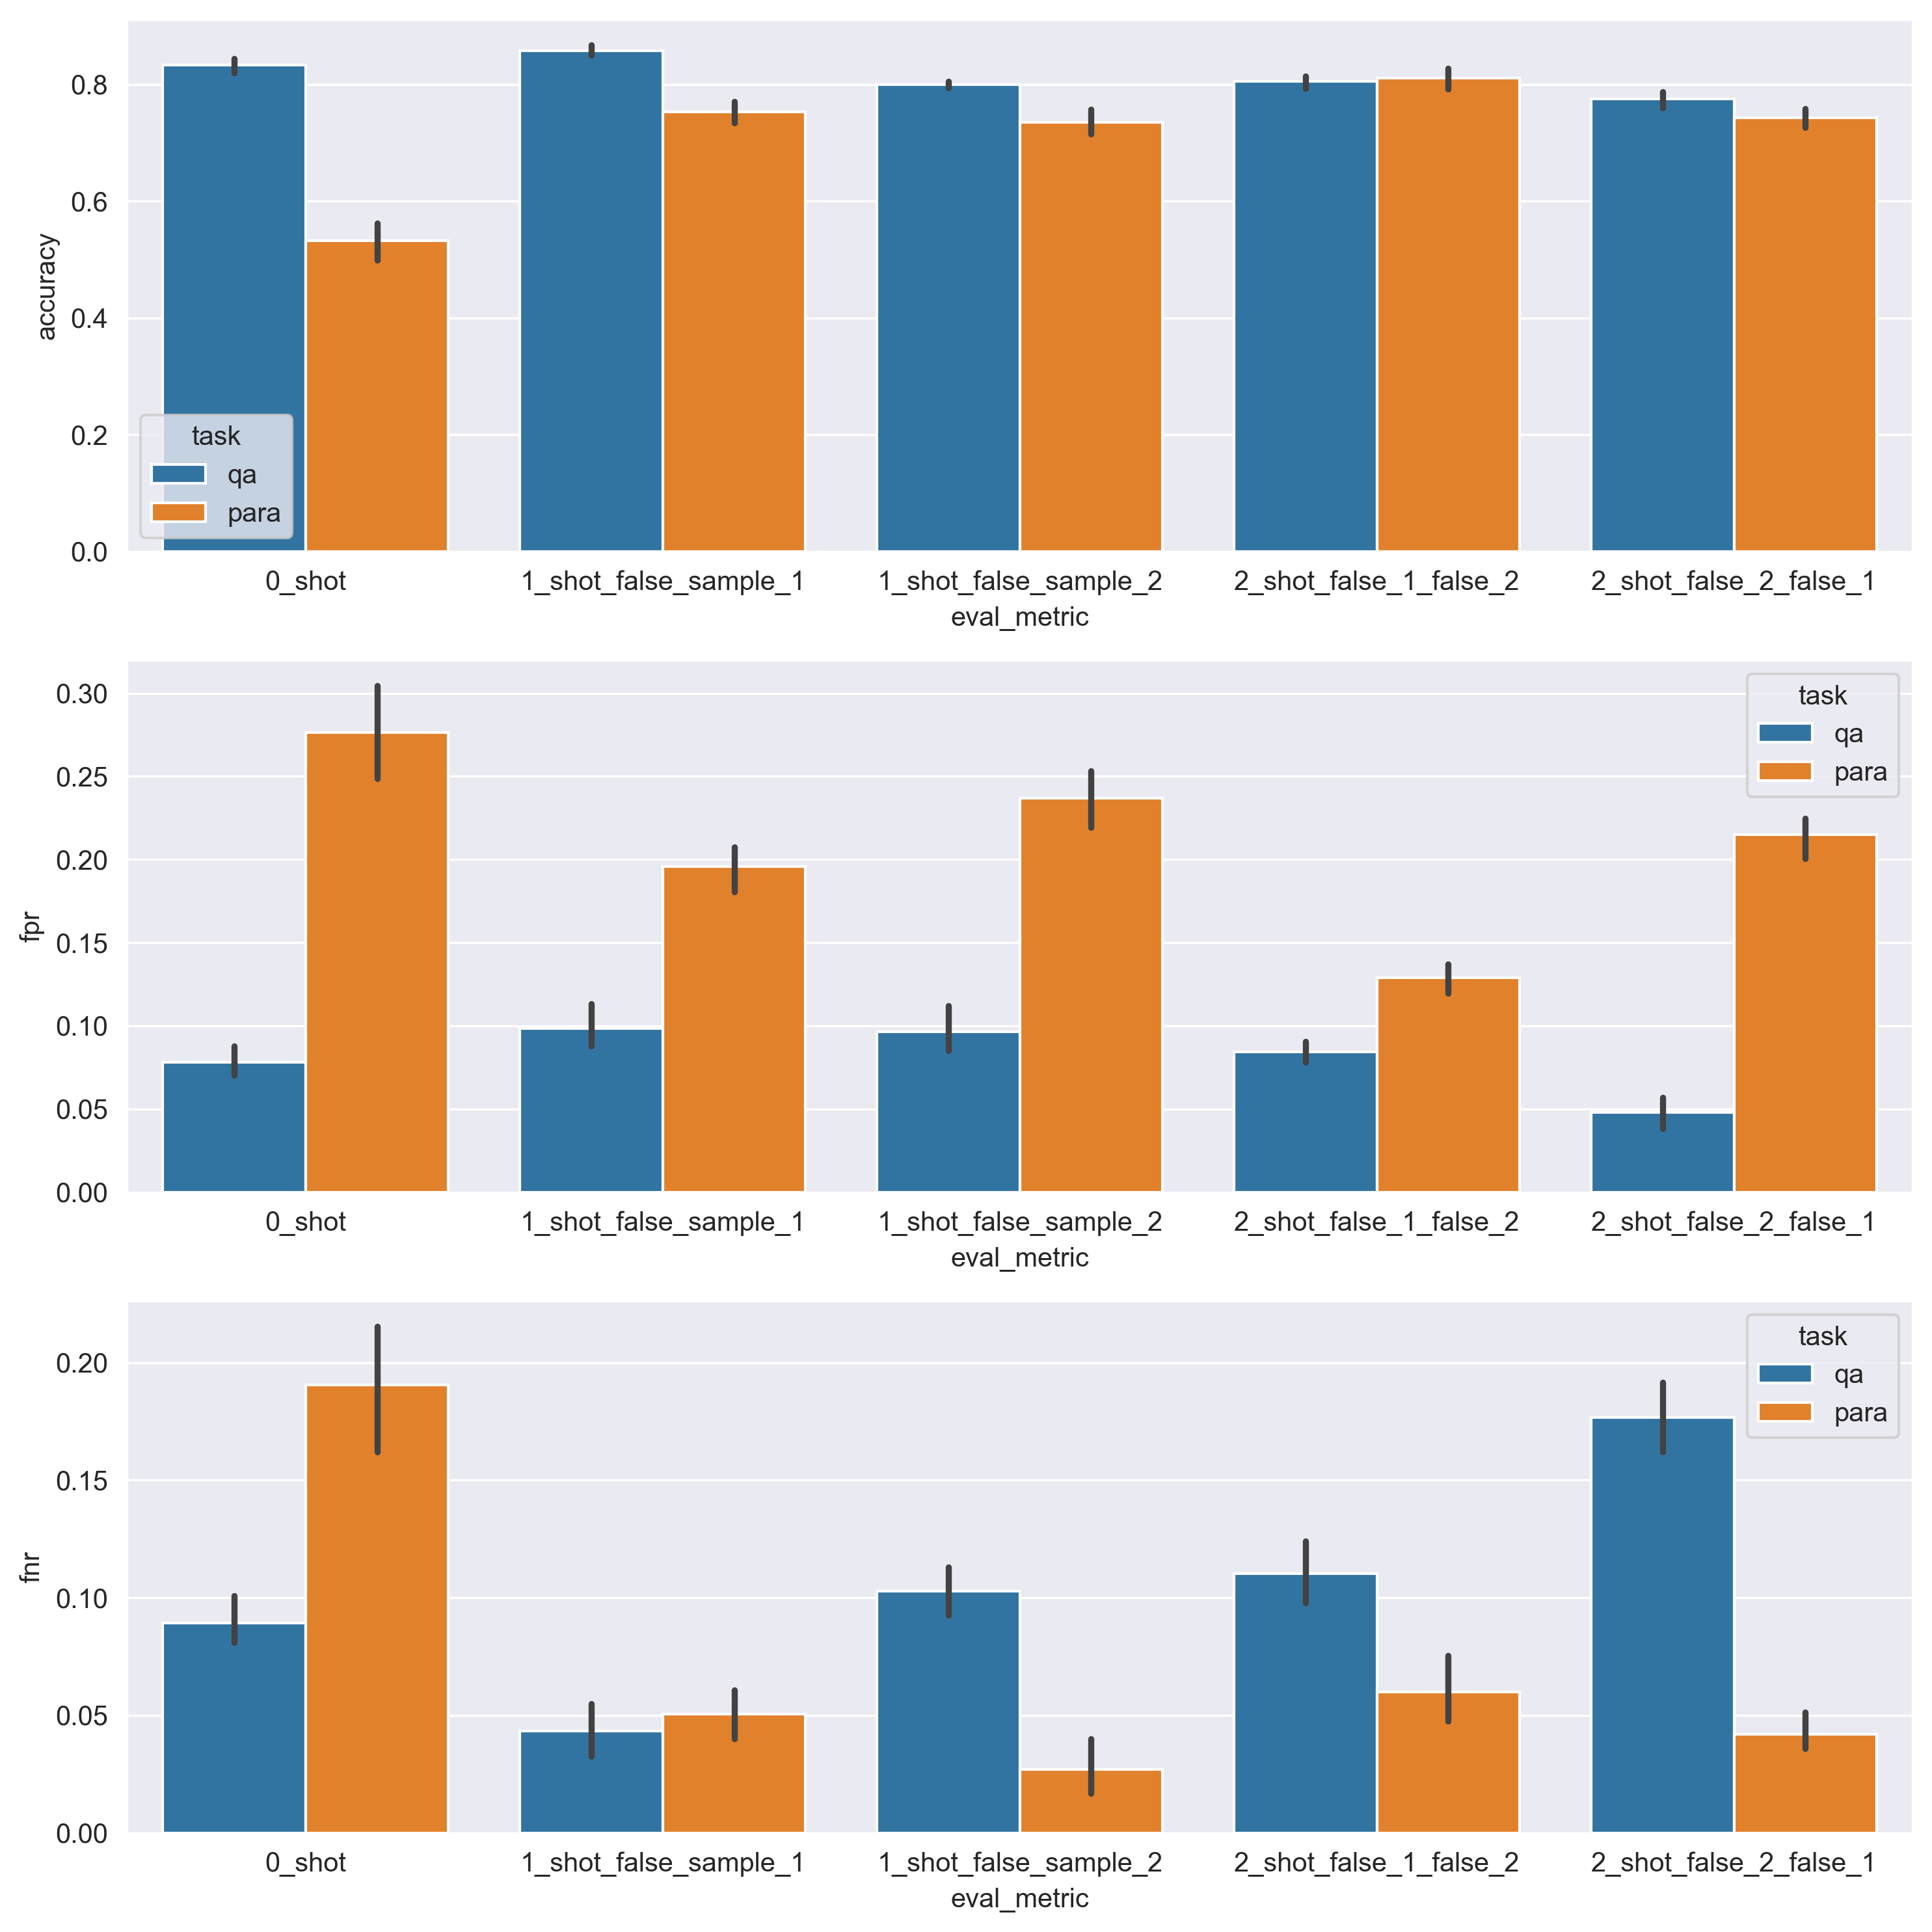

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt

bge_Q_A = analysis('1780cc81-825f-4273-91ee-01151473d41c')
oai_ada_002_qa = analysis('b442feb3-d699-4d35-a41d-932d895f1c39')
oai_small_min_qa = analysis('3aa6a7ae-28bb-4570-92c2-9a8347f42cb9')
oai_small_max_qa = analysis('192b0f86-aca5-4e7e-b251-85a89ea975d8')
oai_large_min_qa = analysis('64518f1b-9f77-4daf-a316-c3671e42f4d8')
oai_large_max_qa = analysis('8704644b-db26-4b44-8c61-778eeaec59d4')
df_qa = pd.concat([bge_Q_A, oai_ada_002_qa, oai_small_min_qa, oai_small_max_qa, oai_large_min_qa, oai_large_max_qa])
df_qa['task'] = 'qa'

bge_Para = analysis('e48d3ea3-1d92-498e-82bb-7967b49d6a9b')
oai_ada_002_para = analysis('c849f3b5-5350-4518-a906-aed0760c8750')
oai_small_min_para = analysis('80ce6c32-6bf4-4b7f-aa93-bc2f528c4dbb')
oai_small_max_para = analysis('249b4566-50f6-4748-955d-e2e70c4eafdc')
oai_large_min_para = analysis('faf6f2b3-afd0-4ee1-bd06-34efd4b1bab0')
oai_large_max_para = analysis('aaa79a2b-bf6b-445c-aba1-b095d341ba7b')
df_para = pd.concat([bge_Para, oai_ada_002_para, oai_small_min_para, oai_small_max_para, oai_large_min_para, oai_large_max_para])
df_para['task'] = 'para'

data = pd.concat([df_qa, df_para])

fig, axs = plt.subplots(3, 1, figsize=(6, 10), dpi = 300)
sns.barplot(data=data, x='eval_metric', y='accuracy', hue='task', ax=axs[0])
sns.barplot(data=data, x='eval_metric', y='fpr', hue='task', ax=axs[1])
sns.barplot(data=data, x='eval_metric', y='fnr', hue='task', ax=axs[2])

plt.tight_layout()
plt.savefig('acc-fpr-fnr.png')

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10), dpi = 300)
sns.barplot(data=data, x='eval_metric', y='accuracy', hue='task', ax=axs[0])
sns.barplot(data=data, x='eval_metric', y='fpr', hue='task', ax=axs[1])
sns.barplot(data=data, x='eval_metric', y='fnr', hue='task', ax=axs[2])

plt.tight_layout()
plt.savefig('acc-fpr-fnr.png')